In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from pmdarima.arima import auto_arima
import emd
from matplotlib import rcParams

In [2]:
plt.style.use('ggplot')
rcParams['figure.figsize'] = 12, 5
rcParams['pdf.fonttype'] = 3
rcParams['font.size'] = 8
rcParams['axes.linewidth'] = 1

In [3]:
df = pd.read_csv('./../data/weather_dataset_preprocesado.csv')
target_column = 'T (degC)'
target_index = 'datetime'
load = df[target_column]
time = df[target_index]
x_label = 'Time'
y_label = 'Temperature (°C)'

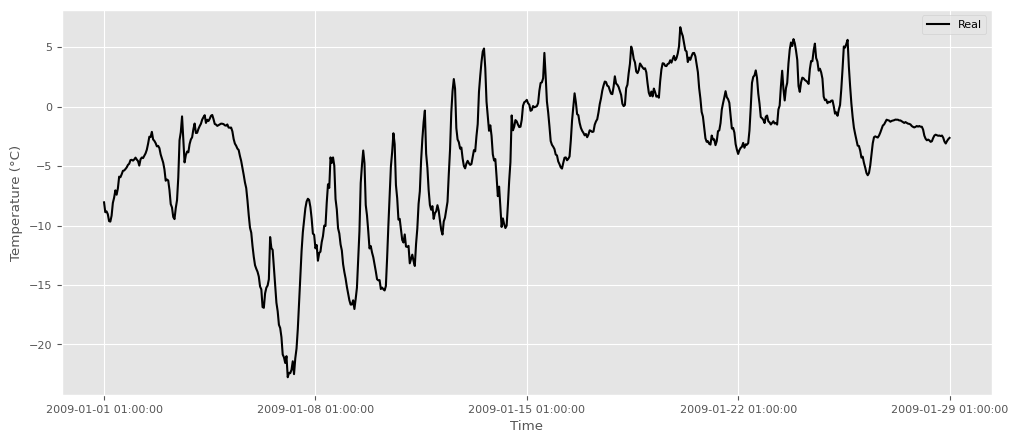

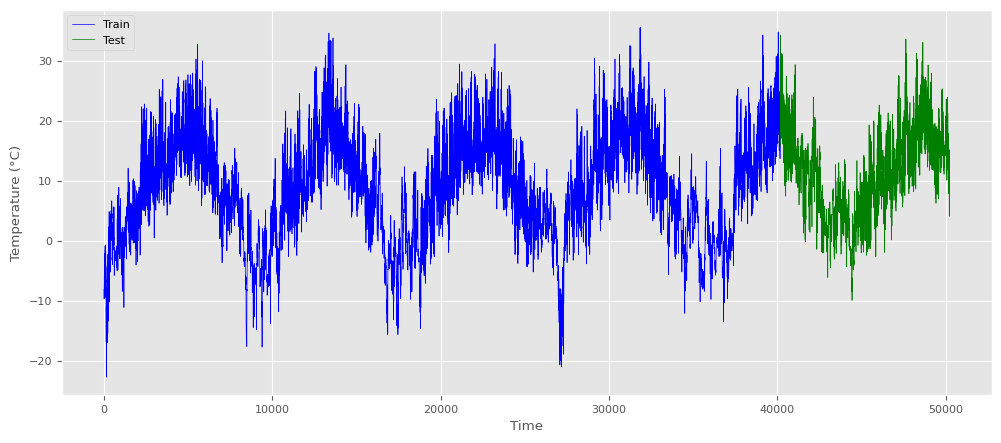

,lag1,lag2,lag3
0,-8.05,-8.05,-8.05
1,-8.05,-8.05,-8.05
2,-8.88,-8.05,-8.05
3,-8.81,-8.88,-8.05
4,-9.05,-8.81,-8.88
...,...,...,...
40174,22.40,23.72,26.45
40175,20.36,22.40,23.72
40176,19.28,20.36,22.40
40177,18.88,19.28,20.36


,lag1,lag2,lag3
40179,15.89,15.89,15.89
40180,15.89,15.89,15.89
40181,16.37,15.89,15.89
40182,18.50,16.37,15.89
40183,21.14,18.50,16.37
...,...,...,...
50219,13.17,10.36,8.01
50220,13.69,13.17,10.36
50221,14.19,13.69,13.17
50222,14.99,14.19,13.69


In [4]:
plt.plot(time[:673], load[:673], color='k', label='Real')
plt.xticks(np.arange(0, 673, step=168))
plt.xlabel(xlabel=x_label)
plt.ylabel(ylabel=y_label)
plt.legend()
plt.show()

train = load[:int(len(load) * 0.8)]
test = load[int(len(load) * 0.8):]
plt.plot(train, label='Train', color='b', linewidth=0.5)
plt.plot(test, label='Test', color='g', linewidth=0.5)
plt.xlabel(xlabel=x_label)
plt.ylabel(ylabel=y_label)
plt.legend()
plt.show()

df_train = pd.DataFrame(train)
df_test = pd.DataFrame(test)
for i in range(1, 4):
    df_train["lag{}".format(i)] = df_train[target_column].shift(i)
    df_test["lag{}".format(i)] = df_test[target_column].shift(i)

df_train = df_train.bfill().drop(columns=[target_column])
df_test = df_test.bfill().drop(columns=[target_column])
display(df_train, df_test)

<Axes: xlabel='Time (samples)'>

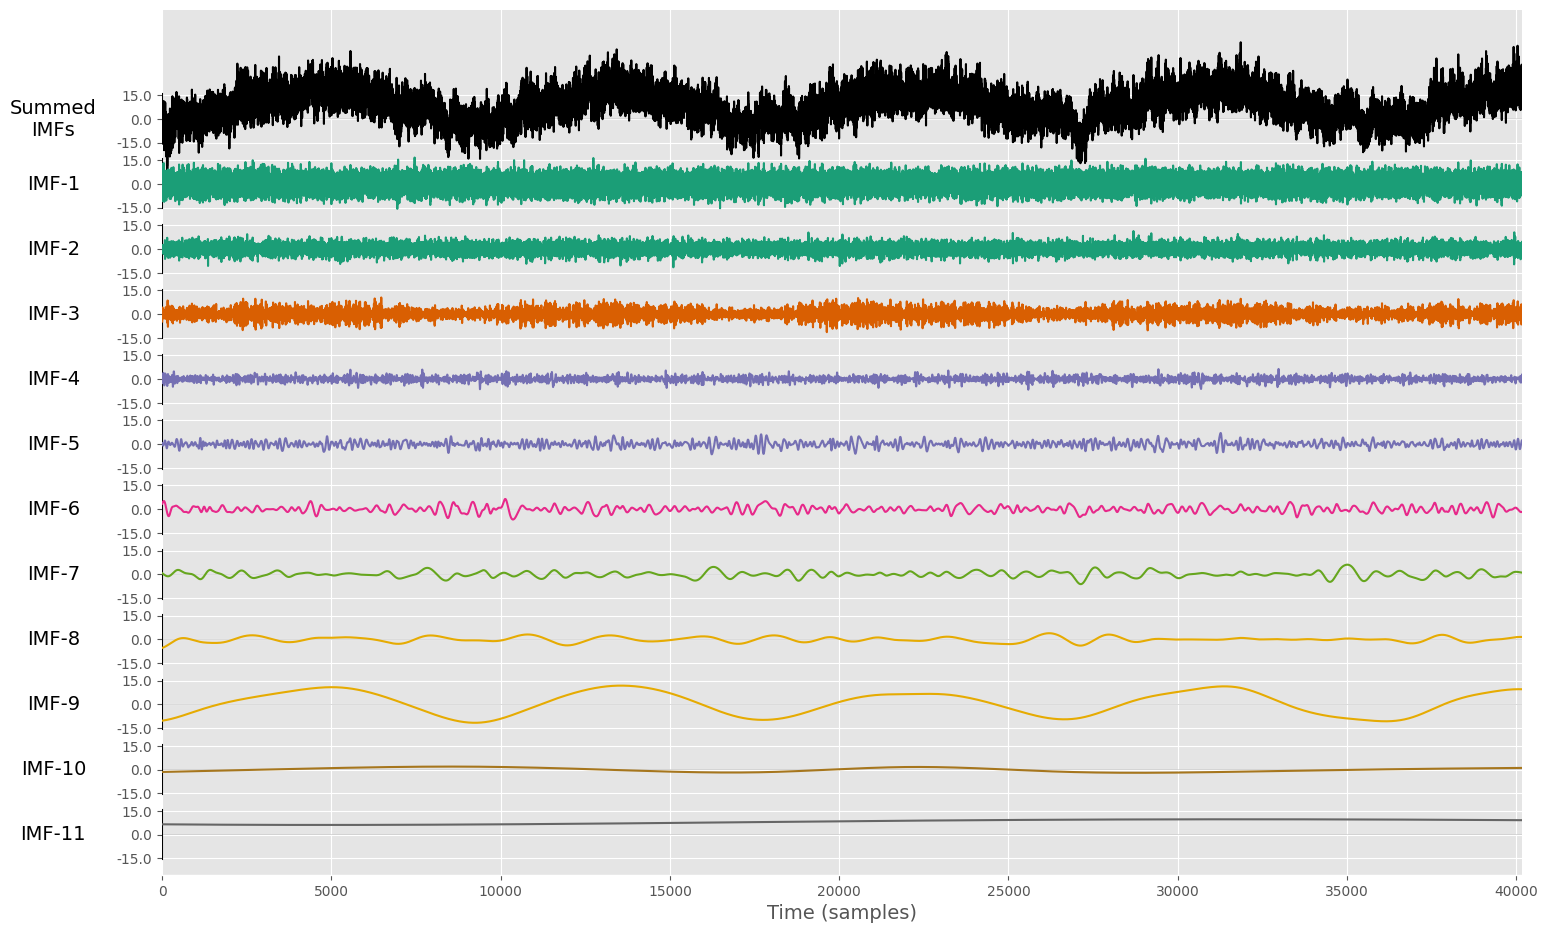

In [5]:
imf_eemd = emd.sift.ensemble_sift(np.array(train), nensembles=4, nprocesses=6, ensemble_noise=1, imf_opts={'sd_thresh': 0.1})
emd.plotting.plot_imfs(imf_eemd)

In [6]:
imf_eemd_df = pd.DataFrame(data=imf_eemd)
imf_eemd_df.columns = ['imf_eemd_{}'.format(i+1) for i in range(imf_eemd.shape[1])]
display(imf_eemd_df)

,imf_eemd_1,imf_eemd_2,imf_eemd_3,imf_eemd_4,imf_eemd_5,imf_eemd_6,imf_eemd_7,imf_eemd_8,imf_eemd_9,imf_eemd_10,imf_eemd_11
0,12.067377,1.050294,-4.733313,-2.492408,0.611874,3.492761,0.712053,-5.360518,-10.210420,-1.516139,6.499566
1,-0.341799,1.309330,-3.943160,-2.336925,0.525991,3.550585,0.694812,-5.353535,-10.207356,-1.515668,6.499385
2,-3.576649,0.580315,-2.858958,-2.163681,0.441481,3.608102,0.677609,-5.346497,-10.204283,-1.515196,6.499204
3,8.518253,-0.901151,-1.598047,-1.975242,0.358458,3.665262,0.660445,-5.339404,-10.201200,-1.514725,6.499023
4,-1.740246,-2.016725,-0.260461,-1.774176,0.277034,3.722017,0.643319,-5.332256,-10.198108,-1.514253,6.498842
...,...,...,...,...,...,...,...,...,...,...,...
40174,-4.089830,-4.835680,-4.507259,2.961483,2.528932,-1.613429,1.072619,1.551191,9.584603,1.032628,9.086426
40175,2.215681,-5.329607,-5.465810,2.985262,2.536164,-1.600248,1.071348,1.550430,9.583882,1.032790,9.086296
40176,3.864557,-0.419927,-5.765352,2.985590,2.536179,-1.586585,1.070133,1.549650,9.583153,1.032952,9.086166
40177,-6.960225,3.492563,-5.478467,2.962639,2.528960,-1.572445,1.068976,1.548853,9.582417,1.033114,9.086036


In [38]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Entrenamiento y predicción con LSTM
def train_lstm_model(imf_series, train_data, test_length):
    model = Sequential()
    model.add(LSTM(10, return_sequences=True, input_shape=(1, 1)))
    model.add(LSTM(10))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(np.array(imf_series).reshape(-1, 1, 1), np.array(train_data), epochs=10, verbose=0)
    forecast = model.predict(np.array(imf_series[-test_length:]).reshape(-1, 1, 1))
    return forecast

In [39]:
imf1_eemd_lstm = train_lstm_model(imf_eemd_df['imf_eemd_1'], train, len(test))
imf2_eemd_lstm = train_lstm_model(imf_eemd_df['imf_eemd_2'], train, len(test))
imf3_eemd_lstm = train_lstm_model(imf_eemd_df['imf_eemd_3'], train, len(test))
imf4_eemd_lstm = train_lstm_model(imf_eemd_df['imf_eemd_4'], train, len(test))
imf5_eemd_lstm = train_lstm_model(imf_eemd_df['imf_eemd_5'], train, len(test))
imf6_eemd_lstm = train_lstm_model(imf_eemd_df['imf_eemd_6'], train, len(test))
imf7_eemd_lstm = train_lstm_model(imf_eemd_df['imf_eemd_7'], train, len(test))
imf8_eemd_lstm = train_lstm_model(imf_eemd_df['imf_eemd_8'], train, len(test))
imf9_eemd_lstm = train_lstm_model(imf_eemd_df['imf_eemd_9'], train, len(test))
imf10_eemd_lstm = train_lstm_model(imf_eemd_df['imf_eemd_10'], train, len(test))

314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [42]:
# Sumar las predicciones de cada modelo LSTM
imf_eemd_fc = np.sum([imf1_eemd_lstm, imf2_eemd_lstm, imf3_eemd_lstm,
                      imf4_eemd_lstm, imf5_eemd_lstm, imf6_eemd_lstm,
                      imf7_eemd_lstm, imf8_eemd_lstm, imf9_eemd_lstm, 
                      imf10_eemd_lstm], axis=0)

In [44]:
imf_eemd_fc.shape

(10045, 1)

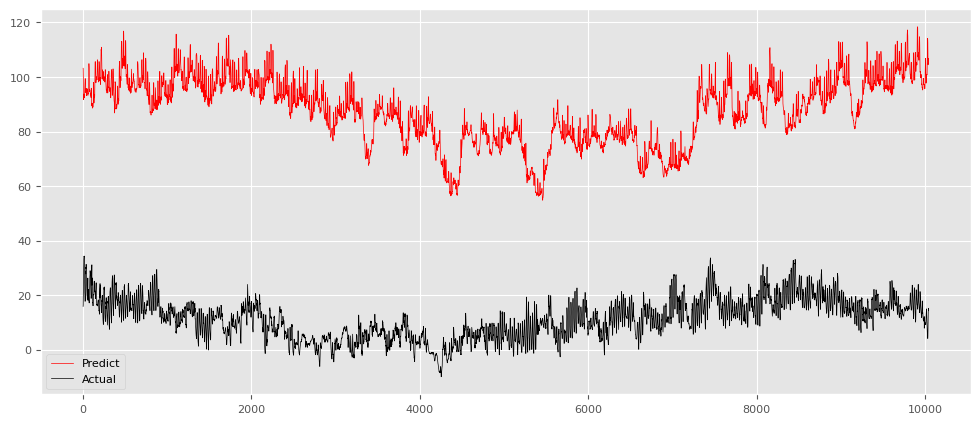

In [45]:
# Graficar predicciones vs valores reales
plt.plot(imf_eemd_fc, label='Predict', color='r', linewidth=0.5)
plt.plot(test.values, label='Actual', color='k', linewidth=0.5)
plt.legend()
plt.savefig('EEMD_LSTM')
plt.show()


In [29]:
# Calcular métricas de error
# RMSE_EEMD_LSTM = mean_squared_error(test, imf_eemd_fc, squared=False)
MAE_EEMD_LSTM = mean_absolute_error(test, imf_eemd_fc)
MAPE_EEMD_LSTM = mean_absolute_percentage_error(test, imf_eemd_fc)
print('MAE = {}'.format(MAE_EEMD_LSTM), '\nMAPE = {}'.format(MAPE_EEMD_LSTM))

314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [23]:
import numpy as np
from keras.layers import LSTM, Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping

# Crear una lista para almacenar las predicciones
imf_lstm_forecasts = []

# Longitud del conjunto de prueba
test_length = len(test)

# Función para crear y entrenar el modelo LSTM
def train_lstm_model(imf_series, train_data, test_length):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(1, 1)))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(np.array(imf_series).reshape(-1, 1, 1), np.array(train_data), epochs=10, verbose=0)
    forecast = model.predict(np.array(imf_series[-test_length:]).reshape(-1, 1, 1))
    return forecast

# Iterar sobre cada serie temporal (IMF) en los datos
for i in range(1, 11):
    imf_series = imf_eemd_df[f'imf_eemd_{i}']
    forecast = train_lstm_model(imf_series, train, test_length)
    imf_lstm_forecasts.append(forecast)


c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [24]:
# # Convertir la lista de predicciones a un array de NumPy
# imf_lstm_forecasts = np.array(imf_lstm_forecasts).reshape(10, test_length)

# Sumar las predicciones de cada modelo LSTM
imf_eemd_fc = np.sum(imf_lstm_forecasts, axis=0)

# Verificar la forma de las predicciones sumadas
print(imf_eemd_fc.shape)  # Debería ser (10045,)
print(test.values.shape)  # Debería ser (10045,)

(10045, 1)
(10045,)


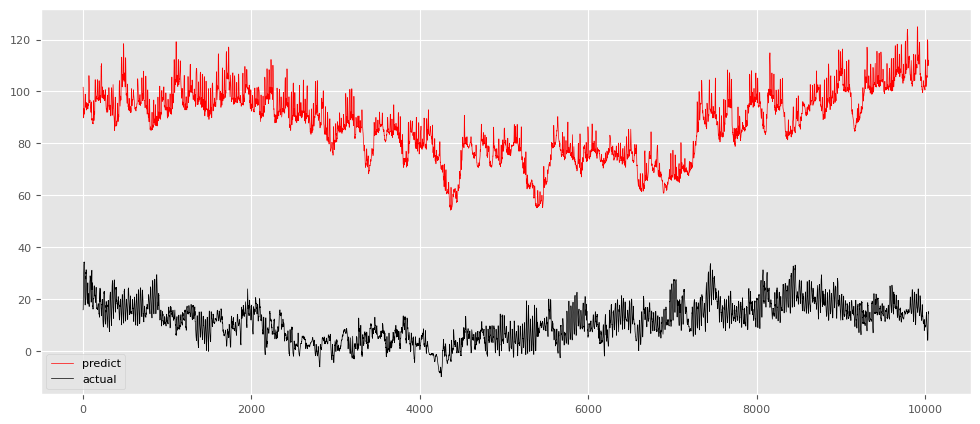

MAE = 76.46174587192412 
MAPE = 76388584022088.75


In [25]:
plt.plot(imf_eemd_fc,label = 'predict', color = 'r', linewidth = 0.5)
plt.plot(test.values, label = 'actual', color = 'k', linewidth = 0.5)
plt.legend()
plt.savefig('EEMDSVR')
plt.show()

# RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc)
MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc)
MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc)
print('MAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))

In [19]:
from keras.layers import LSTM, Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping

# input_shape = imf_eemd_df['imf_eemd_1'].shape
forecasts = []

imf1_eemd_lstm = Sequential()
imf1_eemd_lstm.add(LSTM(50, return_sequences=True))
imf1_eemd_lstm.add(LSTM(50))
imf1_eemd_lstm.add(Dense(1))
imf1_eemd_lstm.compile(optimizer='adam', loss='mse')
imf1_eemd_lstm.summary()
imf1_eemd_lstm.fit(np.array(imf_eemd_df['imf_eemd_1']).reshape(-1, 1, 1), np.array(train), epochs=10, verbose=0)
imf1_eemd_lstm_fc = imf1_eemd_lstm.predict(np.array(imf_eemd_df['imf_eemd_1']).reshape(-1, 1, 1))

imf2_eemd_lstm = Sequential()  
imf2_eemd_lstm.add(LSTM(50, return_sequences=True))
imf2_eemd_lstm.add(LSTM(50))
imf2_eemd_lstm.add(Dense(1))
imf2_eemd_lstm.compile(optimizer='adam', loss='mse')
imf2_eemd_lstm.summary()
imf2_eemd_lstm.fit(np.array(imf_eemd_df['imf_eemd_2']).reshape(-1, 1, 1), np.array(train), epochs=10, verbose=0)
imf2_eemd_lstm_fc = imf2_eemd_lstm.predict(np.array(imf_eemd_df['imf_eemd_2']).reshape(-1, 1, 1))

imf3_eemd_lstm = Sequential()
imf3_eemd_lstm.add(LSTM(50, return_sequences=True))
imf3_eemd_lstm.add(LSTM(50))
imf3_eemd_lstm.add(Dense(1))
imf3_eemd_lstm.compile(optimizer='adam', loss='mse')
imf3_eemd_lstm.summary()
imf3_eemd_lstm.fit(np.array(imf_eemd_df['imf_eemd_3']).reshape(-1, 1, 1), np.array(train), epochs=10, verbose=0)
imf3_eemd_lstm_fc = imf3_eemd_lstm.predict(np.array(imf_eemd_df['imf_eemd_3']).reshape(-1, 1, 1))

imf4_eemd_lstm = Sequential()
imf4_eemd_lstm.add(LSTM(50, return_sequences=True))
imf4_eemd_lstm.add(LSTM(50))
imf4_eemd_lstm.add(Dense(1))
imf4_eemd_lstm.compile(optimizer='adam', loss='mse')
imf4_eemd_lstm.summary()
imf4_eemd_lstm.fit(np.array(imf_eemd_df['imf_eemd_4']).reshape(-1, 1, 1), np.array(train), epochs=10, verbose=0)
imf4_eemd_lstm_fc = imf4_eemd_lstm.predict(np.array(imf_eemd_df['imf_eemd_4']).reshape(-1, 1, 1))

imf5_eemd_lstm = Sequential()
imf5_eemd_lstm.add(LSTM(50, return_sequences=True))
imf5_eemd_lstm.add(LSTM(50))
imf5_eemd_lstm.add(Dense(1))
imf5_eemd_lstm.compile(optimizer='adam', loss='mse')
imf5_eemd_lstm.summary()
imf5_eemd_lstm.fit(np.array(imf_eemd_df['imf_eemd_5']).reshape(-1, 1, 1), np.array(train), epochs=10, verbose=0)
imf5_eemd_lstm_fc = imf5_eemd_lstm.predict(np.array(imf_eemd_df['imf_eemd_5']).reshape(-1, 1, 1))

imf6_eemd_lstm = Sequential()
imf6_eemd_lstm.add(LSTM(50, return_sequences=True))
imf6_eemd_lstm.add(LSTM(50))
imf6_eemd_lstm.add(Dense(1))
imf6_eemd_lstm.compile(optimizer='adam', loss='mse')
imf6_eemd_lstm.summary()
imf6_eemd_lstm.fit(np.array(imf_eemd_df['imf_eemd_6']).reshape(-1, 1, 1), np.array(train), epochs=10, verbose=0)
imf6_eemd_lstm_fc = imf6_eemd_lstm.predict(np.array(imf_eemd_df['imf_eemd_6']).reshape(-1, 1, 1))

imf7_eemd_lstm = Sequential()
imf7_eemd_lstm.add(LSTM(50, return_sequences=True))
imf7_eemd_lstm.add(LSTM(50))
imf7_eemd_lstm.add(Dense(1))
imf7_eemd_lstm.compile(optimizer='adam', loss='mse')
imf7_eemd_lstm.summary()
imf7_eemd_lstm.fit(np.array(imf_eemd_df['imf_eemd_7']).reshape(-1, 1, 1), np.array(train), epochs=10, verbose=0)
imf7_eemd_lstm_fc = imf7_eemd_lstm.predict(np.array(imf_eemd_df['imf_eemd_7']).reshape(-1, 1, 1))

imf8_eemd_lstm = Sequential()
imf8_eemd_lstm.add(LSTM(50, return_sequences=True))
imf8_eemd_lstm.add(LSTM(50))
imf8_eemd_lstm.add(Dense(1))
imf8_eemd_lstm.compile(optimizer='adam', loss='mse')
imf8_eemd_lstm.summary()
imf8_eemd_lstm.fit(np.array(imf_eemd_df['imf_eemd_8']).reshape(-1, 1, 1), np.array(train), epochs=10, verbose=0)
imf8_eemd_lstm_fc = imf8_eemd_lstm.predict(np.array(imf_eemd_df['imf_eemd_8']).reshape(-1, 1, 1))

imf9_eemd_lstm = Sequential()
imf9_eemd_lstm.add(LSTM(50, return_sequences=True))
imf9_eemd_lstm.add(LSTM(50))
imf9_eemd_lstm.add(Dense(1))
imf9_eemd_lstm.compile(optimizer='adam', loss='mse')
imf9_eemd_lstm.summary()
imf9_eemd_lstm.fit(np.array(imf_eemd_df['imf_eemd_9']).reshape(-1, 1, 1), np.array(train), epochs=10, verbose=0)
imf9_eemd_lstm_fc = imf9_eemd_lstm.predict(np.array(imf_eemd_df['imf_eemd_9']).reshape(-1, 1, 1))

imf10_eemd_lstm = Sequential()
imf10_eemd_lstm.add(LSTM(50, return_sequences=True))
imf10_eemd_lstm.add(LSTM(50))
imf10_eemd_lstm.add(Dense(1))
imf10_eemd_lstm.compile(optimizer='adam', loss='mse')
imf10_eemd_lstm.summary()
imf10_eemd_lstm.fit(np.array(imf_eemd_df['imf_eemd_10']).reshape(-1, 1, 1), np.array(train), epochs=10, verbose=0)
imf10_eemd_lstm_fc = imf10_eemd_lstm.predict(np.array(imf_eemd_df['imf_eemd_10']).reshape(-1, 1, 1))

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_32 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_33 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_34 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

KeyboardInterrupt: 

In [15]:
imf_eemd_list = ['imf{}_eemd_lstm_fc'.format(i) for i in range(1,11)]

In [10]:
# imf_eemd_fc = np.sum(imf_arima_forecasts, axis=0)

In [16]:
imf_eemd_fc = np.sum([imf1_eemd_lstm_fc, imf2_eemd_lstm_fc, imf3_eemd_lstm_fc,
                imf4_eemd_lstm_fc, imf5_eemd_lstm_fc,imf6_eemd_lstm_fc,
                imf7_eemd_lstm_fc,imf8_eemd_lstm_fc,imf9_eemd_lstm_fc, imf10_eemd_lstm_fc], axis = 0)

In [17]:
imf_eemd_fc.shape

(40179, 1)

In [18]:
test.values.shape

(10045,)

In [ ]:
imf_eemd_fc

In [ ]:
plt.plot(imf_eemd_fc,label = 'predict', color = 'r', linewidth = 0.5)
plt.plot(test.values, label = 'actual', color = 'k', linewidth = 0.5)
plt.legend()
plt.savefig('EEMDSVR')
plt.show()

# RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc)
MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc)
MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc)
print('MAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))